In [1]:
MAX_EPOCHS = 500
BATCH_SIZE = 128
LEARNING_RATE = 0.001
SMILES_COL = 'Column3'
WAVELENGTH_COL = 'Column5'
URL = '/home/ishii/graduation_research/data/csvファイル/dft_B3LYP_6-31G*_zinc_for-sale_1000000_0to100000.csv'

In [2]:
#変更後のデータセット
import torch
import pandas as pd
from collections import Counter

class Dataset(torch.utils.data.Dataset):
    def __init__(self, url, smiles_col, wavelength_col):
        self.max_length = 0
        self.dummy_char = '_'
        
        self.url = url
        self.smiles_col = smiles_col
        self.smiles = []
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()
        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}
        self.words_indexes = [self.word_to_index[w] for w in self.words]

        self.wavelength_col = wavelength_col
        self.wavelengths = []
        self.items = self.generate_items()
        
        self.dummmy_index = self.word_to_index[self.dummy_char]

    def load_words(self):
        train_df = pd.read_csv(self.url, usecols=[SMILES_COL])
        self.smiles = list(train_df[self.smiles_col])
        for i, smile in enumerate(self.smiles):
            new_smile = smile[1:]
            self.smiles[i] = new_smile
        self.max_length = max(len(smile) for smile in self.smiles)
        self.smiles = list(smile.ljust(self.max_length, self.dummy_char) for smile in self.smiles)
        train_df = pd.Series(self.smiles)
        text = train_df.str.cat(sep=' ')
        text = "".join(text.split(' '))
        return [text[i] for i in range(len(text))]
    
    def generate_items(self):
        train_df = pd.read_csv(self.url, usecols=[WAVELENGTH_COL])
        self.wavelengths = list(train_df[self.wavelength_col])
        items = []
        for i, smile in enumerate(self.smiles):
            smile = list(smile)
            items.append([self.word_to_index[w] for w in smile])
        return items

    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __len__(self):
        return len(self.wavelengths)

    def __getitem__(self, index):
        return (
            torch.tensor(self.items[index]),
            torch.tensor(self.wavelengths[index])
        )

In [3]:
#変更後のモデル
import torch

class bid_LSTM_Predictor(torch.nn.Module):
    def __init__(self, dataset):
        super(bid_LSTM_Predictor, self).__init__()
        self.lstm_size = 128
        self.embedding_dim = 128
        self.num_layers = 3

        n_vocab = len(dataset.uniq_words)
        self.embedding = torch.nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
            padding_idx=dataset.dummmy_index
        )
        self.lstm = torch.nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            batch_first=True,
            dropout=0.2,
            bidirectional = True
        )
        self.fc = torch.nn.Linear(2 * self.lstm_size, 1)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)

        return logits, state

    def init_state(self, batch_size):
        return (torch.zeros(2 * self.num_layers, batch_size, self.lstm_size),
                torch.zeros(2 * self.num_layers, batch_size, self.lstm_size))

In [4]:
# Log in to your W&B account
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: asidaka. Use `wandb login --relogin` to force relogin


True

In [5]:
wandb.init(
    # Set the project where this run will be logged
    project="moleculer_property_prediction", 
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"experiment_LSTM_wavelength_bid", 
    # Track hyperparameters and run metadata
    config={
    "batch_size": BATCH_SIZE,
    "learning_rate": LEARNING_RATE,
    "dataset": "/home/ishii/graduation_research/MAT-master/data/wavelength/smiles_wavelength.csv",
    "epochs": MAX_EPOCHS,
    "lstm_size": 128,
    "embedding_dim": 128,
    "num_layers": 3,
    "dropout": 0.2
    })

In [6]:
#変更後の訓練プロセス
import torch
import numpy as np

def train(dataset, train_dataset, model):
    losses = []
    val_losses = []
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    for epoch in range(MAX_EPOCHS):
        model.train()
        
        state_h, state_c = model.init_state(BATCH_SIZE)
        state_h = state_h.to(device)
        state_c = state_c.to(device)
        total_loss = 0
        total_val_loss = 0

        for batch, (x, y) in enumerate(train_dataloader):
            if batch < int(len(train_dataloader) * 0.75):
                model.train()
                
                optimizer.zero_grad()
                
                y_pred, (state_h, state_c) = model(x.to(device), (state_h, state_c))
                y_pred_permute = torch.permute(y_pred, (2, 1, 0))
                loss = criterion(y_pred_permute[0, dataset.max_length-1], y.to(device))
                total_loss += loss.item()

                state_h = state_h.detach()
                state_c = state_c.detach()

                loss.backward()
                optimizer.step()
                
            else:
                model.eval()
                
                y_pred, (state_h, state_c) = model(x.to(device), (state_h, state_c))
                y_pred_permute = torch.permute(y_pred, (2, 1, 0))
                val_loss = criterion(y_pred_permute[0, dataset.max_length-1], y.to(device))
                total_val_loss += val_loss.item()    
                
                state_h = state_h.detach()
                state_c = state_c.detach()
        
        average_total_train_loss = total_loss / int(len(train_dataloader) * 0.75)
        average_total_val_loss = total_val_loss / (len(train_dataloader) - int(len(train_dataloader) * 0.75))
      
        # 🐝 2️⃣ Log metrics from your script to W&B
        wandb.log({"train_Loss": average_total_train_loss, "val_Loss": average_total_val_loss})
  
        print("Epoch: {}, train_Loss: {:.3f}, val_Loss: {:.3f}".format(
            epoch+1, 
            average_total_train_loss,
            average_total_val_loss
        ))
        losses.append(average_total_train_loss)
        val_losses.append(average_total_val_loss)
    return losses, val_losses

In [7]:
dataset = Dataset(url=URL, smiles_col=SMILES_COL, wavelength_col=WAVELENGTH_COL)
n_samples = len(dataset)
indices = list(range(n_samples))
train_size = int(n_samples * 0.8)
test_size = n_samples - train_size

train_dataset = torch.utils.data.Subset(dataset, indices[:train_size])
test_dataset = torch.utils.data.Subset(dataset, indices[train_size:])

In [9]:
model = bid_LSTM_Predictor(dataset)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
train_losses, val_losses = train(dataset, train_dataset, model)

Epoch: 1, train_Loss: 69187.787, val_Loss: 44124.817
Epoch: 2, train_Loss: 31205.068, val_Loss: 18428.192
Epoch: 3, train_Loss: 13128.308, val_Loss: 7296.150
Epoch: 4, train_Loss: 5927.793, val_Loss: 3575.109
Epoch: 5, train_Loss: 3759.698, val_Loss: 2740.107
Epoch: 6, train_Loss: 3319.823, val_Loss: 2654.932
Epoch: 7, train_Loss: 3273.452, val_Loss: 2668.986
Epoch: 8, train_Loss: 3275.552, val_Loss: 2677.939
Epoch: 9, train_Loss: 3277.011, val_Loss: 2681.547
Epoch: 10, train_Loss: 3276.588, val_Loss: 2683.427
Epoch: 11, train_Loss: 3275.279, val_Loss: 2684.177
Epoch: 12, train_Loss: 3273.293, val_Loss: 2683.674
Epoch: 13, train_Loss: 3270.702, val_Loss: 2681.985
Epoch: 14, train_Loss: 3267.682, val_Loss: 2679.471
Epoch: 15, train_Loss: 3264.499, val_Loss: 2676.629
Epoch: 16, train_Loss: 3261.430, val_Loss: 2673.895
Epoch: 17, train_Loss: 3258.685, val_Loss: 2671.530
Epoch: 18, train_Loss: 3256.375, val_Loss: 2669.627
Epoch: 19, train_Loss: 3254.522, val_Loss: 2668.166
Epoch: 20, train

In [15]:
def predect(dataset, test_dataset, model):
    model.eval()
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=5, drop_last=True)

    index = np.random.choice(len(test_dataloader))
    
    for batch, (x, y) in enumerate(test_dataloader):
    
        smiles, wavelength = x, y
        break
    state_h, state_c = model.init_state(5)
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    y_pred, (state_h, state_c) = model(smiles.to(device), (state_h, state_c))
    y_pred_permute = torch.permute(y_pred, (2, 1, 0))    

    print(y_pred_permute)
    print(wavelength)

In [16]:
predect(dataset, test_dataset, model)

tensor([[[293.2987, 267.6434, 278.4007, 256.0234, 276.9870],
         [321.8479, 275.3440, 273.6069, 269.2428, 256.1450],
         [300.1446, 279.2351, 282.4070, 284.6063, 279.7379],
         [317.2028, 278.2509, 273.0488, 274.4804, 269.0142],
         [356.6292, 285.6224, 285.7785, 303.7660, 284.8510],
         [390.0320, 305.2563, 285.2646, 319.2489, 283.6737],
         [416.0647, 307.8445, 289.5027, 335.2115, 302.5531],
         [445.2879, 292.4807, 318.6165, 345.7350, 304.5890],
         [524.6326, 277.8245, 304.8239, 364.0375, 327.6816],
         [532.2744, 270.4221, 311.9603, 377.1744, 366.8730],
         [597.3447, 302.8230, 330.0548, 390.7117, 416.8093],
         [629.3893, 316.4822, 334.5509, 450.9218, 420.8423],
         [623.5237, 329.3792, 340.8045, 433.6453, 448.2572],
         [583.2706, 357.2257, 343.1219, 397.3820, 417.2019],
         [548.2797, 351.6292, 308.0952, 354.6483, 423.2553],
         [554.1119, 363.6640, 319.6273, 367.8444, 422.0349],
         [535.3646, 367.

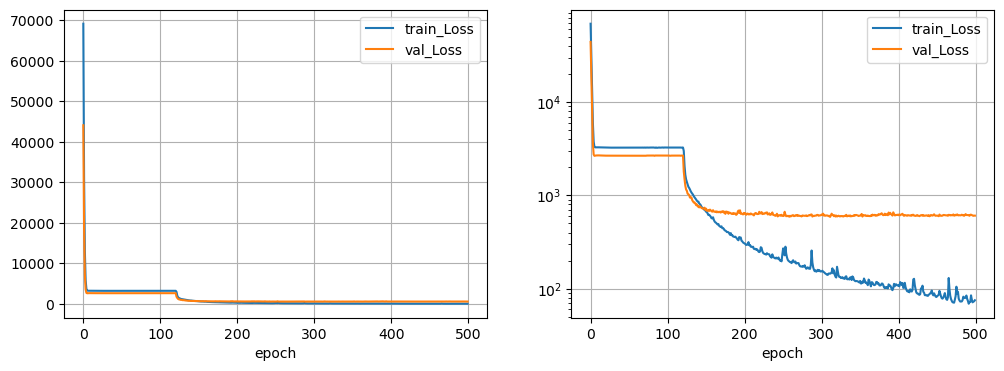

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].plot(train_losses, label="train_Loss")
axes[0].plot(val_losses, label="val_Loss")
axes[0].grid()
axes[0].set_xlabel("epoch")
axes[0].legend()


axes[1].plot(train_losses, label="train_Loss")
axes[1].plot(val_losses, label="val_Loss")
axes[1].grid()
axes[1].set_yscale('log')
axes[1].set_xlabel("epoch")
axes[1].legend()

plt.show()

In [11]:
def test_L1(dataset, test_dataset, model):
    model.eval()
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=True)
    
    criterion = torch.nn.L1Loss()
    
    total_loss = 0
    state_h, state_c = model.init_state(len(test_dataset))
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    
    for batch, (x, y) in enumerate(test_dataloader):
    
        y_pred, (state_h, state_c) = model(x.to(device), (state_h, state_c))
        y_pred_permute = torch.permute(y_pred, (2, 1, 0))    
        loss = criterion(y_pred_permute[0, dataset.max_length-1], y.to(device))
        total_loss += loss.item()

        state_h = state_h.detach()
        state_c = state_c.detach()
    
    return total_loss
        


In [12]:
test_L1_result = test_L1(dataset, test_dataset, model)
# If you had a test set, this is how you could log it as a Summary metric
wandb.summary['test_L1_Loss'] = test_L1_result
print("test_L1_Loss: {:.3f}".format(test_L1_result))

test_L1_Loss: 23.647


In [13]:
def test_MSE(dataset, test_dataset, model):
    model.eval()
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=True)
    
    criterion = torch.nn.MSELoss()
    
    total_loss = 0
    state_h, state_c = model.init_state(len(test_dataset))
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    
    for batch, (x, y) in enumerate(test_dataloader):
    
        y_pred, (state_h, state_c) = model(x.to(device), (state_h, state_c))
        y_pred_permute = torch.permute(y_pred, (2, 1, 0))    
        loss = criterion(y_pred_permute[0, dataset.max_length-1], y.to(device))
        total_loss += loss.item()

        state_h = state_h.detach()
        state_c = state_c.detach()
    
    return total_loss
        


In [14]:
test_MSE_result = test_MSE(dataset, test_dataset, model)
# If you had a test set, this is how you could log it as a Summary metric
wandb.summary['test_MSE_Loss'] = test_MSE_result
print("test_MSE_Loss: {:.3f}".format(test_MSE_result))

test_MSE_Loss: 1128.681


In [15]:
wandb.finish()

train_Loss,█▅▅▅▅▅▅▅▅▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_Loss,█▆▆▆▆▆▆▆▆▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_L1_Loss,23.64726
test_MSE_Loss,1128.68103
train_Loss,75.17503
val_Loss,606.63809
